the number of iterations is = 3053
the charge density is: 0.6587160093365231
the charge per unit length is 4.138834751467213


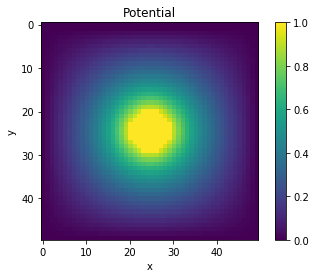

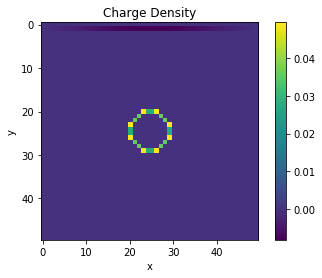

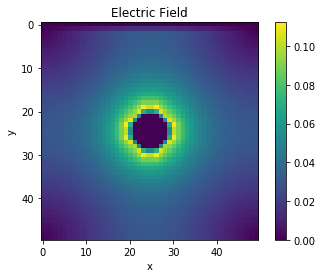

In [102]:
import numpy as np
import matplotlib.pyplot as plt


#Size of the box
N = 50 
# Choosing a distance between grid points
dist=500/N
# Circle radius
rad = 1.0
x = np.linspace(-dist/2, dist/2, N)
y = x
X,Y = np.meshgrid(x,y)
# Now set the potential at the circle and build the matrix V
V_0 = 1.0
V = np.zeros((N,N))
in_cyl=np.sqrt(X**2 + Y**2) <= rad
V[in_cyl] = V_0

ite = 0
# setting a convergence threshold 
thresh = 1e-6 
err = 10
while err > thresh:
    V_new = np.copy(V)
    err = 0
    ite+=1# we make this accumulate in the loop for j in range(2,N-1):
    for j in range(1,N-1):
        for k in range(1,N-1):
            r = np.sqrt(x[j]**2+y[k]**2)
            # solve only outside the circle
            if r > rad:
                V[k,j] = 0.25*(V_new[k+1,j] + V_new[k-1,j]+V_new[k,j-1] + V_new[k,j+1])
                # reset boundary conditions
                V[:,0],V[:,-1],V[1,:],V[-1,:]=0,0,0,0
                V[np.sqrt(X**2 + Y**2) < rad] = V0
                # calculate error
                err += abs(V[k,j]-V_new[k,j])
    
    #err /= float(N)

print("the number of iterations is =",ite)
plt.figure()
plt.title('Potential')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(V)
plt.colorbar()
rho = np.zeros((N,N))

for j in range(1,N-1):
        for k in range(1,N-1):
            rho[k,j] = V[k,j] - 0.25*(V[k+1,j] + V[k-1,j]+V[k,j-1] + V[k,j+1])
            
# Plotting 
plt.figure()
plt.title("Charge Density")
plt.xlabel('x')
plt.ylabel('y')
#plt.contourf(X,Y,rho)
plt.imshow(rho)
plt.colorbar()

# Check that the electric field is 0 inside the conductor

E = np.gradient(V)
E_mag = np.sqrt(E[0]**2+E[1]**2)

plt.figure()
plt.title('Electric Field')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(E_mag)
plt.colorbar()


charge_dens = np.sum(rho)
print('the charge density is:', charge_dens)

charge_len=2*np.pi*rad*charge_dens
print('the charge per unit length is', charge_len)

The analytic charge per unit length is 1.7622421679816398
The analytic charge density is 0.03966438442134855


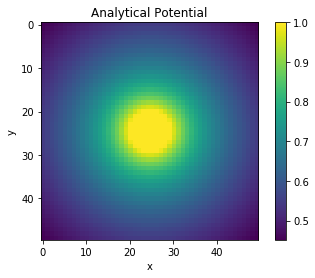

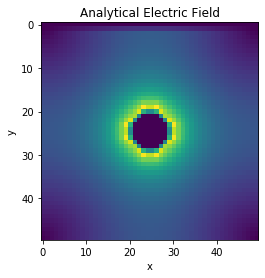

In [105]:

epsi=1 # using 1 as epsilon

#calculating radius of the box that is being used
Rad_box=N/np.sqrt(2)
#calculated the constant, C
cons = V0*np.log(Rad_box)/(np.log(Rad_box)-np.log(rad))
#calculating lambda
lmb = 2*np.pi*cons/np.log(Rad_box)
print('The analytic charge per unit length is', lmb)
print('The analytic charge density is',lmb/(2*np.pi*r))

V_ana = V.copy()
#calculating the analytic solution for the potential
for i in range(len(x)):
    for j in range(len(y)):
        r_sq = x[i]**2+y[j]**2
        r=np.sqrt(r_sq)
        #outside the circle
        if r > rad:
            V_ana[i,j] = (-lmb/(2*np.pi*epsi))*np.log(r)+cons

# Plot the analytic solution
#cs2 = plt.contourf(X,Y,Vanalytic,50)
E_ana=np.gradient(V_ana)
E_ana_mag = np.sqrt(E[0]**2+E[1]**2)

plt.figure()
plt.title('Analytical Potential')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(V_ana)
plt.colorbar()

plt.figure()
plt.title('Analytical Electric Field')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(E_ana_mag)

The analytic charge density is much smaller than that solved with the relaxation method

# Question 2:

final rsqr is  0.0009325696475377921  after  33 iterations


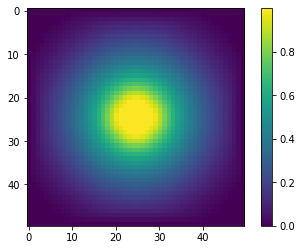

In [84]:
# Solves the left side of the equation
#equations adapted from Jon Sievers code
def Ax(V,mask):
    Vuse=V.copy()
    Vuse[mask]=0
    ans=(Vuse[1:-1,:-2]+Vuse[1:-1,2:]+Vuse[2:,1:-1]+Vuse[:-2,1:-1])/4.0
    ans=ans-V[1:-1,1:-1]
    return ans


#creates 0's at the edges of the matrix so that in calculating V we don't take into account the boundaries

def pad(A):
    AA=np.zeros([A.shape[0]+2,A.shape[1]+2])
    AA[1:-1,1:-1]=A
    return AA

# Paramaters
N = 50
dist=500/N
rad = 1.0
V0 = 1.0

# Creating the matrices for the bc's and making the meshgrid
bc = np.zeros((N,N))
x = np.linspace(-dist/2, dist/2, N)
y = x
X,Y = np.meshgrid(x,y)

#creating the mask to set the boundary conditions
mask = np.sqrt(X**2 + Y**2) < rad
bc[mask] = V0
mask[:,0]=1
mask[:,-1]=1
mask[0,:]=1
mask[-1,:]=1

V=np.zeros((N,N))

#matrix calculating the using the conjugate gradient method
#adapted from Jon Sievers
def conj_grad(bc,V,mask,niter):
    b = -(bc[1:-1,0:-2]+bc[1:-1,2:]+bc[:-2,1:-1]+bc[2:,1:-1])/4.0
    ax=Ax(V,mask)
    r=b-ax
    p=r.copy()
    r_sq=np.sum(r*r)
    for i in range(niter):
        p_pad=pad(p)
        Ap=Ax(p_pad,mask)
        alpha=np.sum(r*r)/np.sum(Ap*p)
        padded=pad(alpha*p)
        V=V+padded
        r=r-alpha*Ap
        r_sq_new=np.sum(r*r)
        beta=r_sq_new/r_sq
        p=r+beta*p
        r_sq=r_sq_new
        if r_sq<1e-6:
            print('final rsqr is ',r_sq,' after ',i,'iterations')
            break  
    return V

V_conj_grad = conj_grad(bc,V,mask,100)


plt.title('Potential')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(V_conj_grad)
plt.colorbar()



This method converges much faster

# Question 3:

final rsqr is  0.0008637847612425558  after  21 iterations


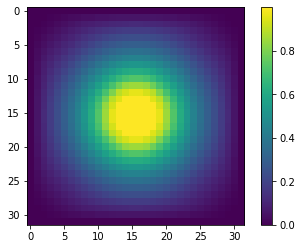

final rsqr is  0.0008235780050695699  after  4 iterations


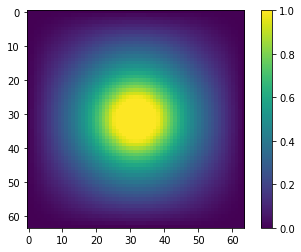

final rsqr is  0.0008055486755591769  after  1 iterations


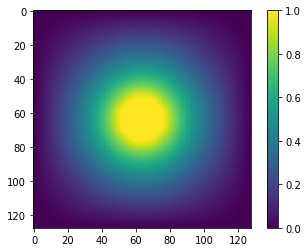

final rsqr is  0.00042536150054424914  after  1 iterations


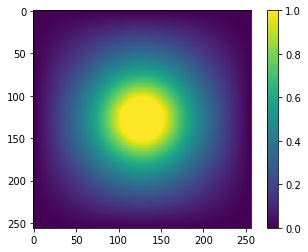

final rsqr is  0.0005532641345381469  after  0 iterations


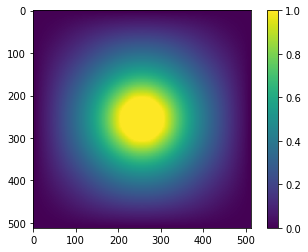

final rsqr is  0.0004723787872829176  after  0 iterations


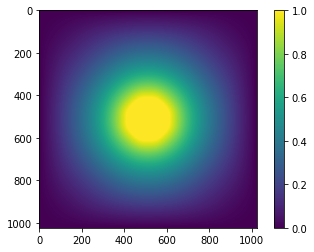

In [89]:
#equations adapted from John Sievers to increase and decrease the resolution of the matrix

def deres_mat(mat):
    #downgrades the 
    mm=np.zeros([mat.shape[0]//2,mat.shape[1]//2],dtype=mat.dtype)
    mm=np.maximum(mm,mat[::2,::2])
    mm=np.maximum(mm,mat[::2,1::2])
    mm=np.maximum(mm,mat[1::2,::2])
    mm=np.maximum(mm,mat[1::2,1::2])
    return mm
def upres_mat(mat):
    #increases the resolution by a factor of 2
    mm=np.zeros([mat.shape[0]*2,mat.shape[1]*2],dtype=mat.dtype)
    mm[::2,::2]=mat
    mm[::2,1::2]=mat
    mm[1::2,::2]=mat
    mm[1::2,1::2]=mat
    return mm


# define the bc and mask
#starting at a resolution of 1024 pixels to downgrade to a coarse 16 pixels
N = 1024
dist=10.0
rad = 1.0
V0 = 1.0

bc = np.zeros((N,N))
x = np.linspace(-dist/2, dist/2, N)
y = x
X,Y = np.meshgrid(x,y)

mask = np.sqrt(X**2 + Y**2) < rad
bc[mask] = 1.0
mask[:,0]=1
mask[:,-1]=1
mask[0,:]=1
mask[-1,:]=1
V=np.zeros((N,N))


n_jump=6
#loop through the resolutions. start with something very coarse then increase resolution by factor of 2 using 
#this as an initial guess
all_masks=[None]*n_jump
all_bc=[None]*n_jump
all_x=[None]*n_jump
all_masks[0]=mask
all_bc[0]=bc
for i in range(1,n_jump):
    all_masks[i]=deres_mat(all_masks[i-1])
    all_bc[i]=deres_mat(all_bc[i-1])


#now, make the lowest-resolution map. Setting up the right hand side using the coarsest resolution

nn=all_masks[-1].shape[0] #.shape[0] gives the dimension of the array, the number of elements
niter=3*nn


#setting up the right hand side of our coarsest resolution image solve
all_x[-1]=conj_grad(all_bc[-1],0*all_bc[-1],all_masks[-1],niter)

#show our lowest-resolution solution
plt.ion()
plt.imshow(all_x[-1])
plt.colorbar()
plt.show()

#and now, run a loop where you increase the resolution, solve for a fixed number of iterations
n_iter=100

for i in range(n_jump-2,-1,-1):
    x0=upres_mat(all_x[i+1])
    all_x[i]=conj_grad(all_bc[i],x0,all_masks[i],n_iter)
    #plot the current-resolution potential
    plt.imshow(all_x[i])
    plt.colorbar()
    plt.pause(0.01)
    

#finally, paste in the boundary conditions since we didn't solve for them in conjugate gradient.
for i in range(n_jump):
    all_x[i][all_masks[i]]=all_bc[i][all_masks[i]]





# Question 4:

final rsqr is  0.0008637847612425558  after  21 iterations
final rsqr is  0.0007508029066751549  after  4 iterations
final rsqr is  0.0008272853619896961  after  1 iterations
final rsqr is  0.00042814232031693146  after  1 iterations
final rsqr is  0.0005574151711917242  after  0 iterations
final rsqr is  0.00046699458487745054  after  0 iterations


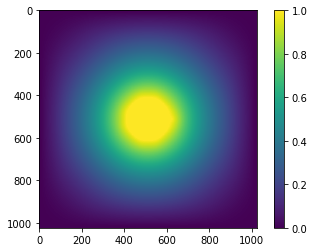

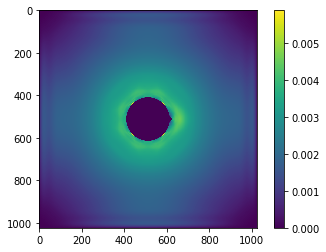

In [90]:
# add a bump that is 10% the radius of the circles

N = 1024
dist=10
rad = 1.0
V0 = 1.0

#same set up as before
x = np.linspace(-dist/2, dist/2, N)
y = x
X,Y = np.meshgrid(x,y)
mask = np.sqrt(X**2 + Y**2) < rad
#creating a mask for the bump by adding 10% bump in the x direction of our circle
bump_mask = np.sqrt((X-rad)**2 + (Y)**2) < (rad*0.1) #adding 10% bump to the wire


#same set up as from problem 3
bc = np.zeros((N,N))
bc[mask] = V0
bc[bump_mask] = V0

mask = np.bool_(bc)
mask[:,0]=1
mask[:,-1]=1
mask[0,:]=1
mask[-1,:]=1

n_jump=6
V=np.zeros((N,N))

all_masks=[None]*n_jump
all_bc=[None]*n_jump
all_x=[None]*n_jump
all_masks[0]=mask
all_bc[0]=bc
for i in range(1,n_jump):
    all_masks[i]=deres_mat(all_masks[i-1])
    all_bc[i]=deres_mat(all_bc[i-1])

nn=all_masks[-1].shape[0] #.shape[0] gives the dimension of the array, the number of elements
n_iter=3*nn

all_x[-1]=conj_grad(all_bc[-1],0*all_bc[-1],all_masks[-1],n_iter)

plt.ion();
plt.imshow(all_x[-1])
plt.colorbar()

#
n_iter=100

for i in range(n_jump-2,-1,-1):
    x0=upres_mat(all_x[i+1])
    all_x[i]=conj_grad(all_bc[i],x0,all_masks[i],niter)
    plt.clf()
    plt.imshow(all_x[i])
    plt.colorbar()
    


for i in range(n_jump):
    all_x[i][all_masks[i]]=all_bc[i][all_masks[i]]



E = np.gradient(all_x[0])
E_mag = np.sqrt(E[0]**2+E[1]**2)
plt.figure()
plt.imshow(E_mag)
plt.colorbar()



# Problem 5

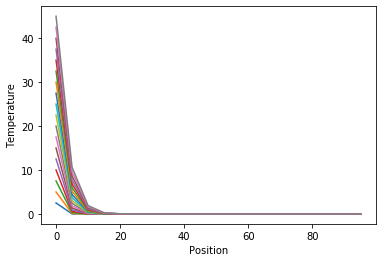

In [96]:
#arbitrarily choosing parameters
#size of the box
N=100
#size of the positional steps
dN=5
dt=0.5
alpha=2
wall_temp=5

x = np.arange(0,N,dN) # array of positions
time = np.arange(0,10,dt) # array of time steps
temp = np.zeros((len(time),len(x))) # saves the value of u at time t and position x
wall_temp = time*wall_temp # array with the increasing temperature of the wall with time
r = alpha*dt/dN**2
    
for i in range(1,len(temp)-1): # loops over time
        # u[row,column]=u[t,x]
    temp[i,0] = wall_temp[i] # set the wall temperature
    for j in range(1,len(x)-1): # loops over space
        temp[i+1,j] = r*temp[i,j+1]+(1-2*r)*temp[i,j]+r*temp[i,j-1] # estimate the temperature at next position
    plt.ion()
    plt.plot(x,temp[i])
    plt.xlabel('Position')
    plt.ylabel('Temperature')
    





#/opt/anaconda3/lib/python3.7/sit

The graph shows a curve of the computed temperature agains the position in the box over time. We set the boudnary condition such that the temperature of one wall increases linearly with time for 10 time steps. This means that along that wall the temp continues to increase until reaching the end of the time steps and the behaviour throughout the box is shown by position 